In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 627 Project - Shelter Animal Outcomes Machine Learning with Random Forest
- Author: Zhongyu Liu, Hollin Han, Yan Ting Chen
- Data: 10/30/2017
- Classification algorithm: RandomForest, Logistic Regression
- Objective: Use classification algorithms to process multiclass classifcation data and predict shelter outcomes.
- Index:
    - [I. Report and Analysis](#Section-I) : Analysis each features and their importance.
    - [II. Algorithms Analysis](#Algorithms-Analysis): Analysis each algorithm.
    - [III. Actual Performance](#Actual-Performance): Generate submission code.
    - [IV. Submission Report](#Submission-Report): Detail report for each submission.

## Section I
We chose the data about shelter animals with multiple class classification since it seems more interesting than binary classification as a machine learning project topic. After fitting several models to our training data, Random Forest turned out to be more efficient than others so that we kept it in our final submission in the leaderboard.
## Report and Analysis

In [2]:
# Load packges to prepare for the analysis
import pandas as pd # data visualization
import seaborn as sns # data visualization

In [3]:
# Read in each data
# Test and train data use to generate the final result
test = pd.read_csv('/Users/JohnnyLiu/Mine/User/MIAMI_UNIVERSITY/Fall_2017/CSE_627/Proj/test.csv')
train = pd.read_csv('/Users/JohnnyLiu/Mine/User/MIAMI_UNIVERSITY/Fall_2017/CSE_627/Proj/train.csv')
# Train_data is used for performance analysis
train_data = pd.read_csv('/Users/JohnnyLiu/Mine/User/MIAMI_UNIVERSITY/Fall_2017/CSE_627/Proj/train.csv')
sample_sub = pd.read_csv('/Users/JohnnyLiu/Mine/User/MIAMI_UNIVERSITY/Fall_2017/CSE_627/Proj/sample_submission.csv')

In [4]:
# Help function to generate performance count probability.
# It will return the probability for each part, seperated by anaimal type.
# Such as for cats who get adopted, 10% of them are teen.
def generate_Count_Prob(table, rounds=2):
    count_p = []
    for i, c in enumerate(table.AnimalType):
        if c == 'Cat':
            count_p.append(round(float(table.Count[i]) / cat_count, rounds))
        else:
            count_p.append(round(float(table.Count[i]) / dog_count, rounds))
    return count_p

In [5]:
# Help function to generate plots for data visualization.
# Grouped by animal type and classifiers. 
def generate_plot(x, table, fs1=25, fs2=12, sp1=2, sp2=5, titles = ['Cat', 'Dog'], 
                  outcome = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']):
    figsize(fs1, fs2)
    for i in range(len(titles)):
        temp = table[table.AnimalType == titles[i]]
        for j in range(len(outcome)):
            subplot(sp1, sp2, i*5+j+1)
            title(titles[i] + '_' + outcome[j])
            ax = sns.barplot(x=x, y='Count_P', data=temp[temp.OutcomeType == outcome[j]])
            ax.set(xlabel='', ylabel='')

### Calculate Animal Count and Missing Data
Before we start modeling, we need to check the total number for dogs and cats as well as the probability of each outcome type. It is aimed to achieve better data visualization in the future analysis. Also, we have to check the number of missing data we have before starting the analysis.

In [6]:
# Get the total number of dog and cat in train data.
dog_count = sum(train_data.AnimalType == 'Dog')
cat_count = sum(train_data.AnimalType == 'Cat')
print 'Total Cat:', cat_count
print 'Total Dog:', dog_count

Total Cat: 11134
Total Dog: 15595


Since there are more dogs than cats, it's really necessary to compare the outcome type by their percentage rather than just use the numbers of data. We will achieve the task in the following cells.

In [7]:
# Distribution of missing data in train data.
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

There are tons of missing names, 1 missing sex and 18 missing ages. There are some other missing outcomes, but they are not very effective for our analysis.

There are approximately 30% of pet names are missing in the training data set. It will not be a problem if we include their names as a predictor variable in the model. Thus, we have simply modelled them with the name as a binary variable: having a name or not.

Compared to names, missing data in sex and age is not that significant. We are going to replace the missing sex with random one (male or female), and replace the missing age data with the mean age.

In [8]:
# Distribution of missing data in test data.
test.isnull().sum()

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

It is likewise the same issue for the test data. We got some missing data on name and age in test data as well. However, it is not a big problem for us. We can replace the 6 missing ages with their average age again.

### Analysis by Animal type

First of all, I would like to see the difference between dogs and cats by plotting, since the plots are pretty self-explaining with corresponding labels.

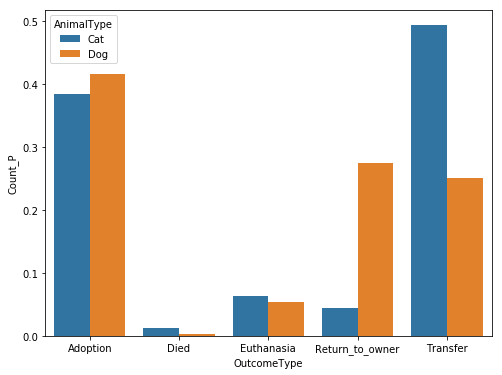

In [9]:
# Generate new train outcome groups by outcome type and calculate probability for each of them.
train_outcome = pd.DataFrame({'Count' : train_data.groupby( [ "AnimalType", "OutcomeType"] ).size()}).reset_index()
train_outcome['Count_P'] = generate_Count_Prob(train_outcome, 3)
figsize(8, 6)

sns.barplot(x="OutcomeType", y='Count_P', hue="AnimalType", data=train_outcome)

Animal type is such an important variable that we cannot get rid of in the future training. As we can see, dogs and cats are commonly adopted, died or euthanasia, where cats have a bit better chance to be adopted than the other two compared with dogs.

For the two groups of either returned to owner or transferred, there is a significant difference between dogs and cats. For a cat, it's more likely to get transferred, while dogs have more chance to be returned to the owner.

### Analysis Age
We will seperate the animal age by the following ranges:
- Teen – 0-6 months.
- Junior – 6 months-2 years.
- Prime – 3-6 years.
- Mature – 7-10 years.
- Senior - 11-14 years.
- Geriatric - 15 years and over.


We get this range from Wikipedia. We should separate the ages as specific as possible, since it might be significant for some outcome types like "died". Hopefully we could get more detailed information by doing so. Also, we think it is important to group the age variable by "is adult" or not. Since teens are more likely to get adopted and transferred, but less likely to get returned to owner (or maybe it doesn't have an owner yet).

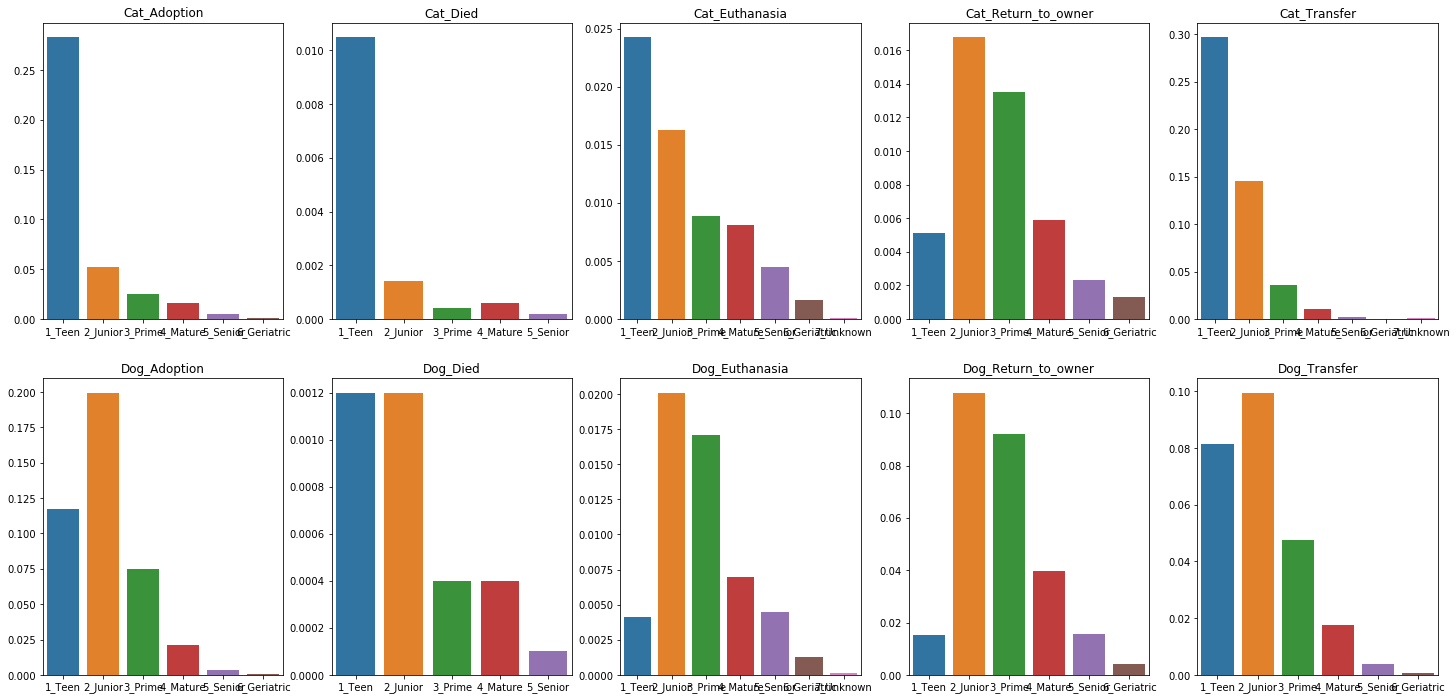

In [10]:
# Group the data by ages, basically for plot I just used help function to
# seperate the age variable by number and month, day, week, years, 
# and put them into corresponding groups, which is pretty strightforward.
age_type = []
for c in train_data.AgeuponOutcome:
    # To deal with missing data, since 'nan' is float type
    if type(c) == float:
        age_type.append('7_Unknown')
        continue
    c = c.split(' ')
    if c[1] == 'month' or c[1] == 'months':
        if int(c[0]) < 7:
            age_type.append('1_Teen')
        else:
            age_type.append('2_Junior')
    elif c[1] == 'year' or c[1] == 'years':
        if int(c[0]) < 3:
            age_type.append('2_Junior')
        elif int(c[0]) < 7:
            age_type.append('3_Prime')
        elif int(c[0]) < 11:
            age_type.append('4_Mature')
        elif int(c[0]) < 15:
            age_type.append('5_Senior')
        else:
            age_type.append('6_Geriatric')
    else:
        age_type.append('1_Teen')
        
train_data['LifeStage'] = age_type

train_outcome_age = pd.DataFrame({'Count' : train_data.groupby([ "AnimalType", "OutcomeType", 'LifeStage']).size()}).reset_index()
train_outcome_age['Count_P'] = generate_Count_Prob(train_outcome_age, 4)

generate_plot('LifeStage', train_outcome_age)

In summary, age is an important variable since there's a huge difference between the age groups. For example, both the cats younger than 6 months and the dogs between half year and 2 years old have a higher possibility to get transferred or adopted. In the future, it would be easier to combine some of these six ranges and simply check if an animal is an adult (1 years old) or not.

### Analysis breed
Classifying the data by their breed is really time consuming. The procedure will be easier if we only consider whether they are mixed or not. However, we think that might not be a significant element if we did it. Thus, we tried to use some ways to separate them base on the breed. One of a good way is to classify them according to their physical shapes. First, we looked up online for those breed types and sorted them by physical shapes. After the groups are built, we used the key words to search and identify them. If there is no key words found in a pet, we might classify it as the others.

In [11]:
# Seperate the variable of breed, with dog by size, cat by hair type to generate six groups of breed as follows:
smallDog = ["Affenpinscher","Australian Terrier","Bedlington Terr","Bichon Frise", "Border Terrier", 
                "Boston Terrier", "Cairn Terrier", "Cavalier", "Chihuahua", "Chinese Crested", "Dachshund", 
                "Havanese", "Italian Greyhound", "Jack Russell Terrier", "Japanese Chin", "Lhasa Apso", 
                "Lowchen", "Maltese", "Manchester Terrier", "Miniature Pinscher", "Miniature Schnauzer", 
                "Norwich Terrier", "Papillon", "Parson Russell Terrier", "Pekingese", "Pomeranian", "Poodle", 
                "Podengo Pequeno", "Rat Terrier", "Schipperke", "Scottish Terrier", "Shiba Inu", "Shih Tzu", 
                "Silky Terrier", "Smooth Fox Terrier", "Welsh Terrier", "West Highland", "Yorkshire Terrier"]
mediumDog = ["Afghan Hound", "Airedale Terrier", "American Eskimo", "American Foxhound", "Australian Cattle",
             "Australian Shepherd", "Basenji", "Basset Hound", "Beagle", "Bearded Collie", "Belgian Malinois", 
             "Border Collie", "Boxer", "Brittany", "Canaan Dog", "Cardigan Welsh Corgi", "Chow Chow", "Cocker Spaniel",
             "Collie", "English Bulldog", "English Pointer", "Field Spaniel", "Finnish Spitz", "German Pinscher", 
             "Glen Of Imaal", "Harrier", "Ibizan Hound", "Irish Terrier", "Keeshond", "Norwegian Elkhound", 
             "Nova Scotia Duck Tolling", "Pembroke Welsh Corgi", "Pharaoh Hound", "Plott Hound", "Coonhound", "Saluki", 
             "Samoyed", "Sealyham Terr", "Shetland Sheepdog", "Siberian Husky", "Skye Terrier", "Soft Coated Wheaten Terrier",
             "Springer Spaniel", "Standard Schnauzer", "Swedish Vallhund", "Tibetan Terrier", "Treeing Walker Coonhound", 
             "Vizsla", "Welsh Springer Spaniel", "Whippet", "Wirehaired Pointing Griff"]
largeDog = ["Inu", "Alaskan Malamute", "American Staffordshire Terrier", "Beauceron", "Bernese Mountain", "Coonhound",
            "Bloodhound", "Boerboel", "Borzoi", "Bull Terrier", "American Bulldog", "Bullmastiff", "Cane Corso",
            "Retriever", "Dalmatian", "Doberman Pinsch", "Dogo Argentino", "English Foxhound", "English Setter", 
            "Flat Coat Retriever", "German Pinscher", "German Shepherd", "German Shorthair Pointer", 
            "German Wirehaired Pointer", "Schnauzer Giant", "Golden Retriever", "Setter", "Great Dane", 
            "Great Pyrenees", "Greater Swiss Mountain Dog", "Irish Setter", "Irish Wolfhound", "Kuvasz", "Mastiff", 
            "Neapolitan Mastiff", "Newfoundland", "Old English Sheepdog", "Otterhound", "Standard Poodle", 
            "Rhod Ridgeback", "St. Bernard", "Spinone Italiano", "Weimaraner"]

shorthairCat = ["Abyssinian", "American Shorthair", "Bombay", "Shorthair", "Burmese", "Domestic Shorthair", 
                "Havana Brown", "Ocicat", "Russian Blue", "Siamese", "Snowshoe", "Tokinese"]
longhairCat = ["Balinese", "Himalayan", "Maine Coon", "Forest", "Persian", "Ragdoll", "Turkish Van"]
mutationCat = ["Bengal", "Cornish", "Cymric", "Devon Rex", "Japanese Bobtail", "Manx", "Pixiebob", "Sphynx"]

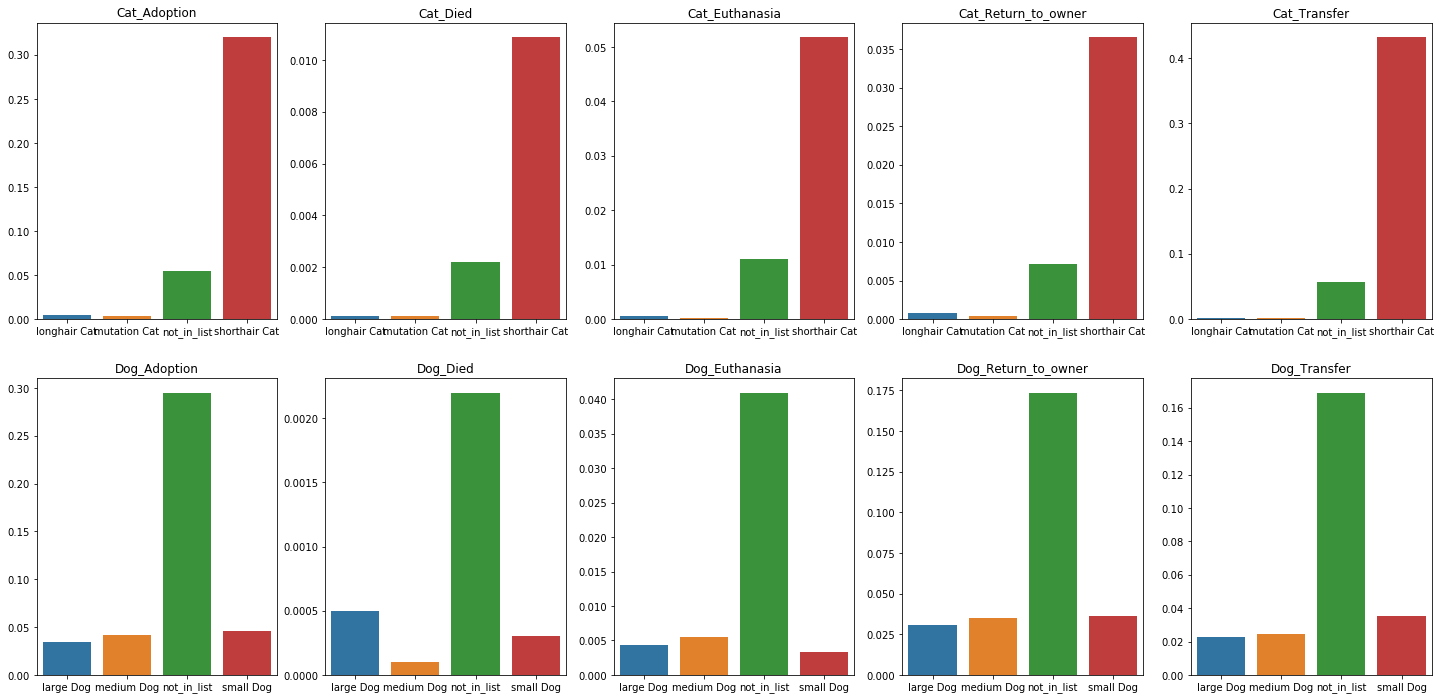

In [12]:
breed_type = []
for c in train_data.Breed:
    if type(c) == float:
        breed_type.append('Unknown')
        continue
    if 'Mix' in c:
        c = c[:c.rindex(' ')]
    if c in smallDog:
        breed_type.append('small Dog')
    elif c in mediumDog:
        breed_type.append('medium Dog')
    elif c in largeDog:
        breed_type.append('large Dog')
    elif c in shorthairCat:
        breed_type.append('shorthair Cat')
    elif c in longhairCat:
        breed_type.append('longhair Cat')
    elif c in mutationCat:
        breed_type.append('mutation Cat')
    else:
        breed_type.append('not_in_list')
train_data['Breed_type'] = breed_type

train_outcome_breed = pd.DataFrame({'Count' : train_data.groupby([ "AnimalType", "OutcomeType", 'Breed_type']).size()}).reset_index()
train_outcome_breed['Count_P'] = generate_Count_Prob(train_outcome_breed, 4)

generate_plot('Breed_type', train_outcome_breed)

The breed is not significantly promising, and there are a lot of missing data in it. That causes all the breed types become messy and difficult to be identified. But we will classify it by "mix" or "not mixed" in the final training, since pure breed may be more popular than mixed. Therefore, "not mixed" should be less likely to die or euthanasia than "mixed".

### Analysis about Color
For animals' color, the first issue is that colors for cats and dogs are generally different. However, we still can find out some commonality such as white and black are very common for both of them.
If we remove some rare colors, there are still more than 20 colors. That was a hard time to analysis them and also not very effective. Thus, we select eight different colors to represent some common colors and classified those rare colors as the others.
The other issue is that most of them have more than one color. So it is not a good idea if we classified white or black first. Because white and black is more common than some colors such as tan or silver. To deal with this problem, we sorted those eight colors based on rare to common to get more helpful information.

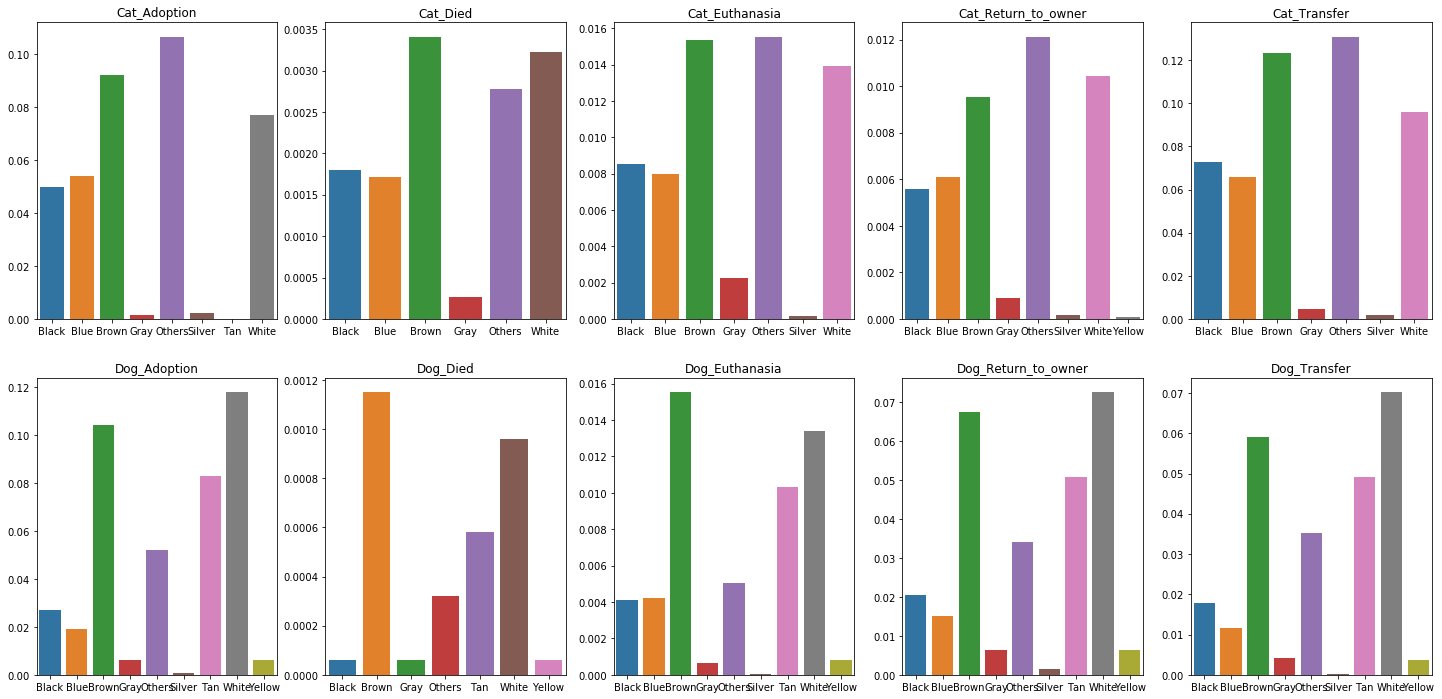

In [13]:
color_type = []
for c in train_data.Color:
    if 'Tan' in c:
        color_type.append('Tan')
    elif 'Silver' in c:
        color_type.append('Silver')
    elif 'Blue' in c:
        color_type.append('Blue')
    elif 'Gray' in c:
        color_type.append('Gray')
    elif 'Yellow' in c:
        color_type.append('Yellow')
    elif 'Brown' in c:
        color_type.append('Brown')
    elif 'White' in c:
        color_type.append('White')
    elif 'Black' in c:
        color_type.append('Black')
    else:
        color_type.append('Others')
train_data['Colors'] = color_type

train_outcome_color = pd.DataFrame({'Count' : train_data.groupby(["AnimalType", "OutcomeType", 'Colors']).size()}).reset_index()
train_outcome_color['Count_P'] = generate_Count_Prob(train_outcome_color, 5)
generate_plot('Colors', train_outcome_color)

The color is not really a good labeling variable neither. One possible reason is that the adoption decision only based on owners’ preferences. Thus, color is not impacting on the outcome type very much. The final log loss score got improved slightly after color being added. We also compared the two groups of animals according to whether they have a mixed color, which can be found in section 3.

### Analysis by date

The date is a pretty interesting variable to analysis. We tried to separate this variable by season and time of day. Besides, we assumed that the same goal could also be achieved by categorizing the time by weeks or months too. The results shown below are classified according to their seasons.

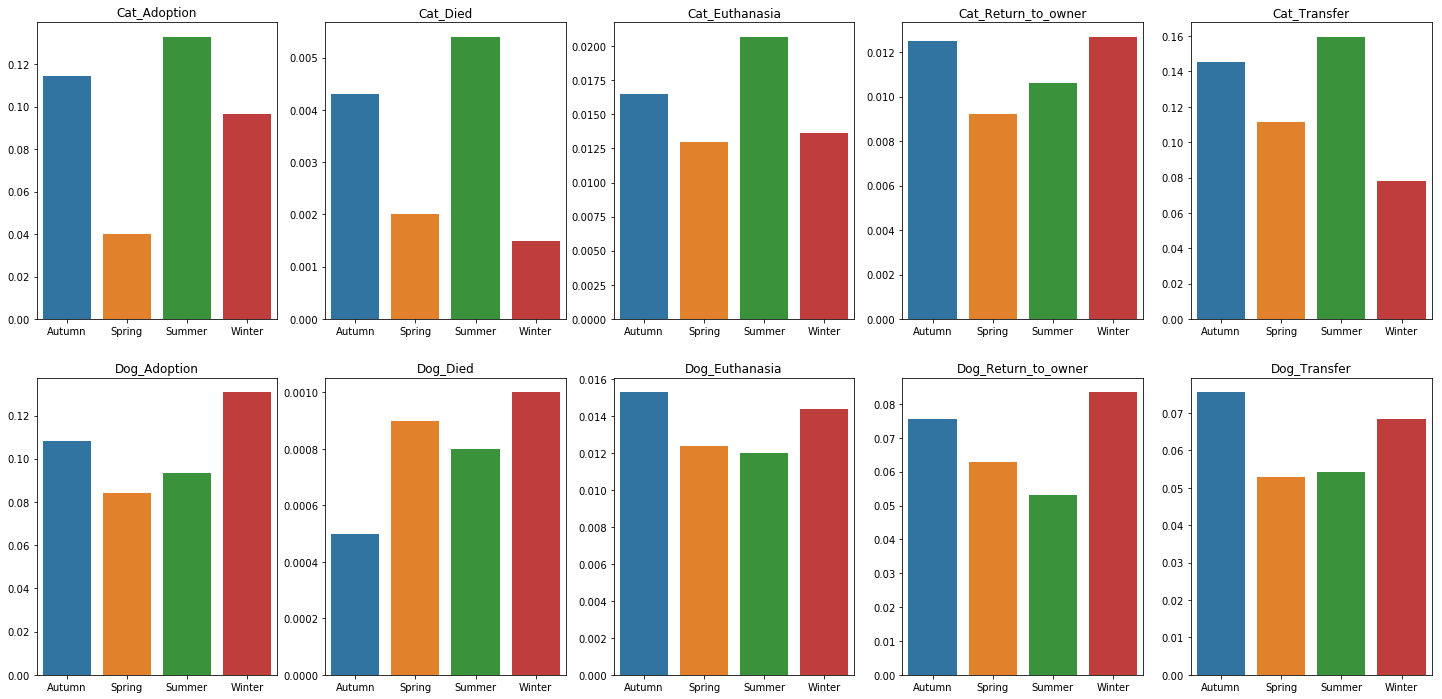

In [14]:
season_type = []
for c in train_data.DateTime:
# Seperate out the month from date and put them into seasons correspondingly.
    c = int(c.split(' ')[0].split('-')[1])
    if c < 3 or c == 12:
        season_type.append('Winter')
    elif c < 6:
        season_type.append('Spring')
    elif c < 9:
        season_type.append('Summer')
    elif c < 12:
        season_type.append('Autumn')
    else:
        season_type.append('Unknown')
train_data['Season'] = season_type

train_outcome_season = pd.DataFrame({'Count' : train_data.groupby([ "AnimalType", "OutcomeType", 'Season']).size()}).reset_index()
train_outcome_season['Count_P'] = generate_Count_Prob(train_outcome_season, 4)
generate_plot('Season', train_outcome_season)

As we can see, the season actually affects the outcome types for different animal types, like summer is a predicting season for cats but autumn is more predicting for dog than other seasons. Thus we should include it in our modeling.

### Analysis by Time of Day

Time of Day is part of the analysis of "date", where we get 'hour' from the variable of date before checking the distribution of each outcome type probabilities by plot histograms. We analysis the time of day because we assumed that the intention of owners to adopt or returning to owner might possibly happen mostly not in the early morning or night. Those procedures are more likely executed in the work hours per day. In order to proof our speculation, we sorted the data shown as below.

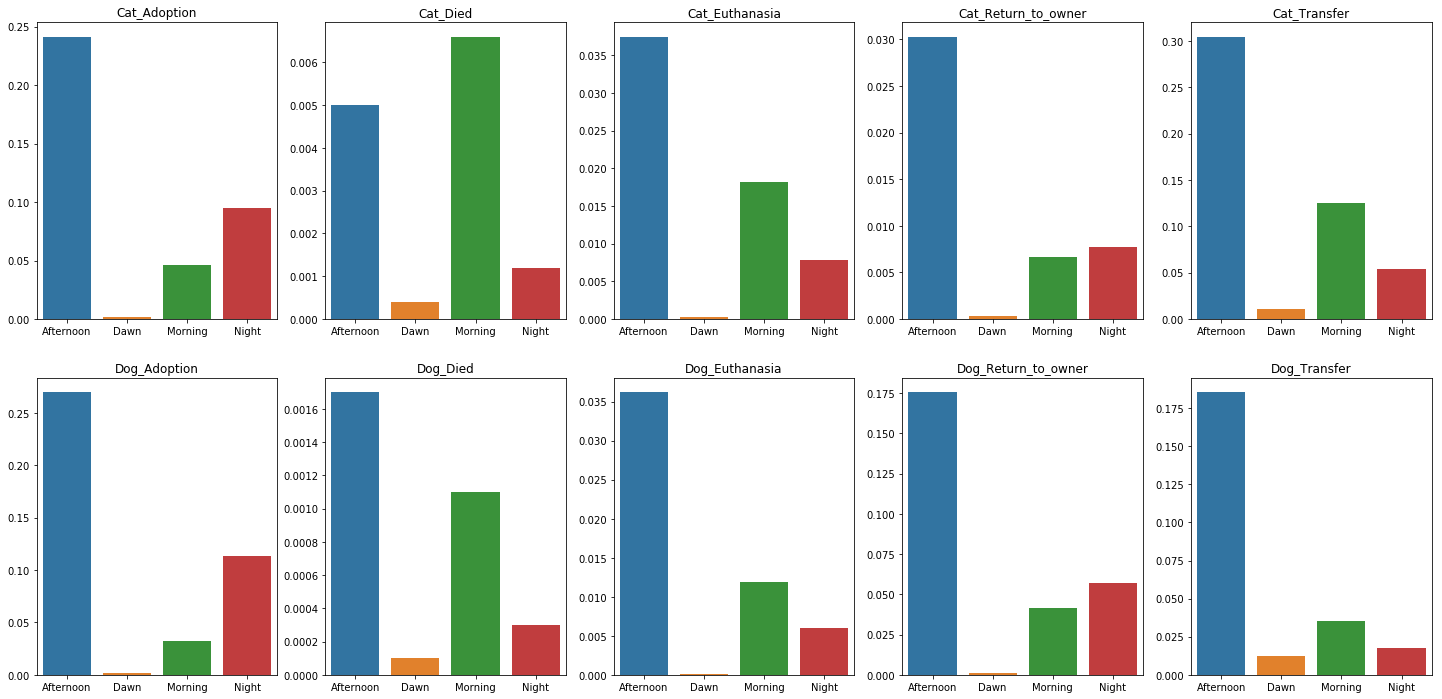

In [15]:
time_type = []
for c in train_data.DateTime:
    c = int(c.split(' ')[1].split(':')[0])
    if c < 6:
        time_type.append('Dawn')
    elif c < 12:
        time_type.append('Morning')
    elif c < 18:
        time_type.append('Afternoon')
    elif c < 24:
        time_type.append('Night')
    else:
        time_type.append('Unknown')
train_data['Time'] = time_type

train_outcome_time = pd.DataFrame({'Count' : train_data.groupby([ "AnimalType", "OutcomeType", 'Time']).size()}).reset_index()
train_outcome_time['Count_P'] = generate_Count_Prob(train_outcome_time, 4)
# train_outcome_time
generate_plot('Time', train_outcome_time)

The afternoon is most of time when everything is happening, but in the morning is more likely for a cat to die. That is reasonable results comparing to our speculations. Most of the events are happening in the afternoon besides any natural circumstances such as death. However, time of date, unfortunately, is not a very significant parameter.

### Analysis by Sex

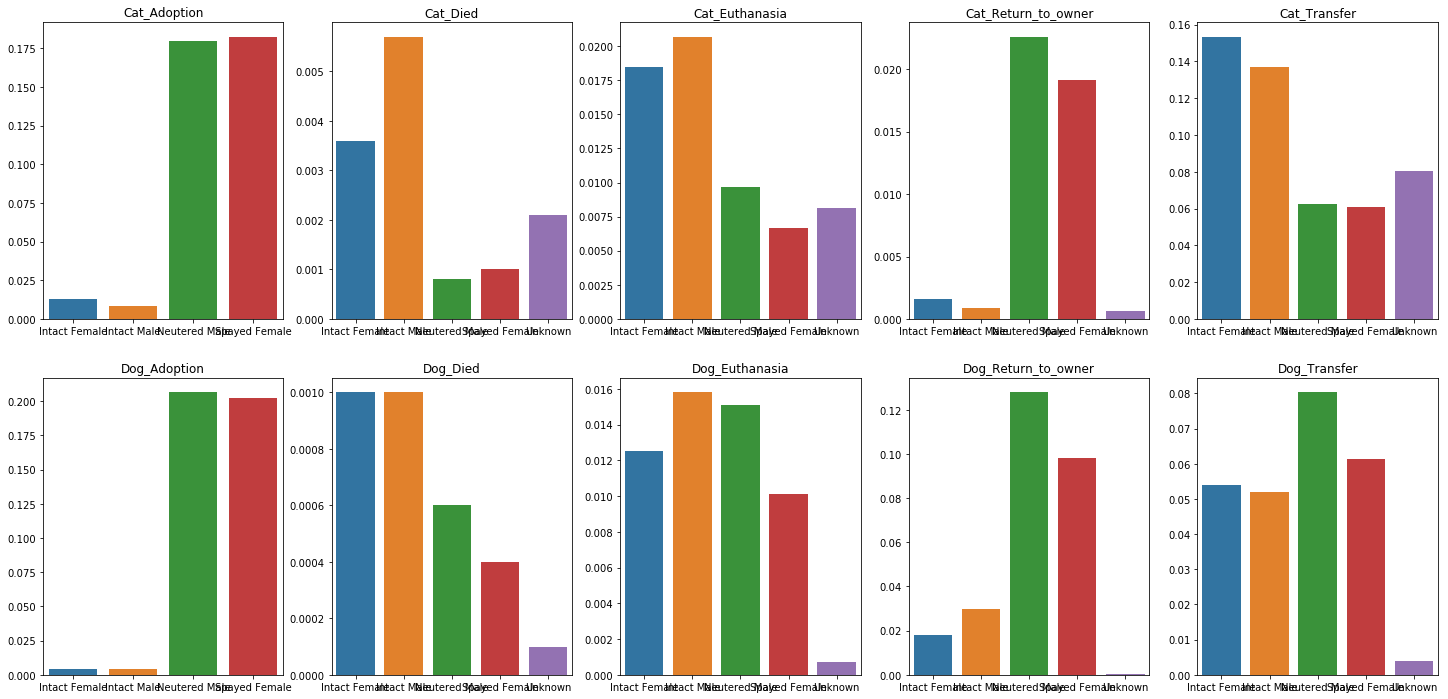

In [16]:
train_outcome_sex = pd.DataFrame({'Count' : train_data.groupby(["AnimalType", "OutcomeType", 'SexuponOutcome']).size()}).reset_index()
train_outcome_sex['Count_P'] = generate_Count_Prob(train_outcome_sex, 4)
generate_plot('SexuponOutcome', train_outcome_sex)

Sex is a pretty predictive variable. Based upon the histogram above, neutered animal is way more likely to be adopted for both cats and dogs. Well, neutered an animal can be pretty expensive, I guess if I have to choose one favorite cat from several candidates, I'll choose the one neutered. In addition, male and female does impact the outcome type, too.

### Analysis by Name
The name of a pet is always an interesting topic. When the owners treated them as family members or even a human, picking a name could possibly a issue that affect the intention of adopting. We all agree upon that pet name would affect the outcome type, but is it statistically impacting the outcome type in the training data? If the answer is yes, we mush take this into account.

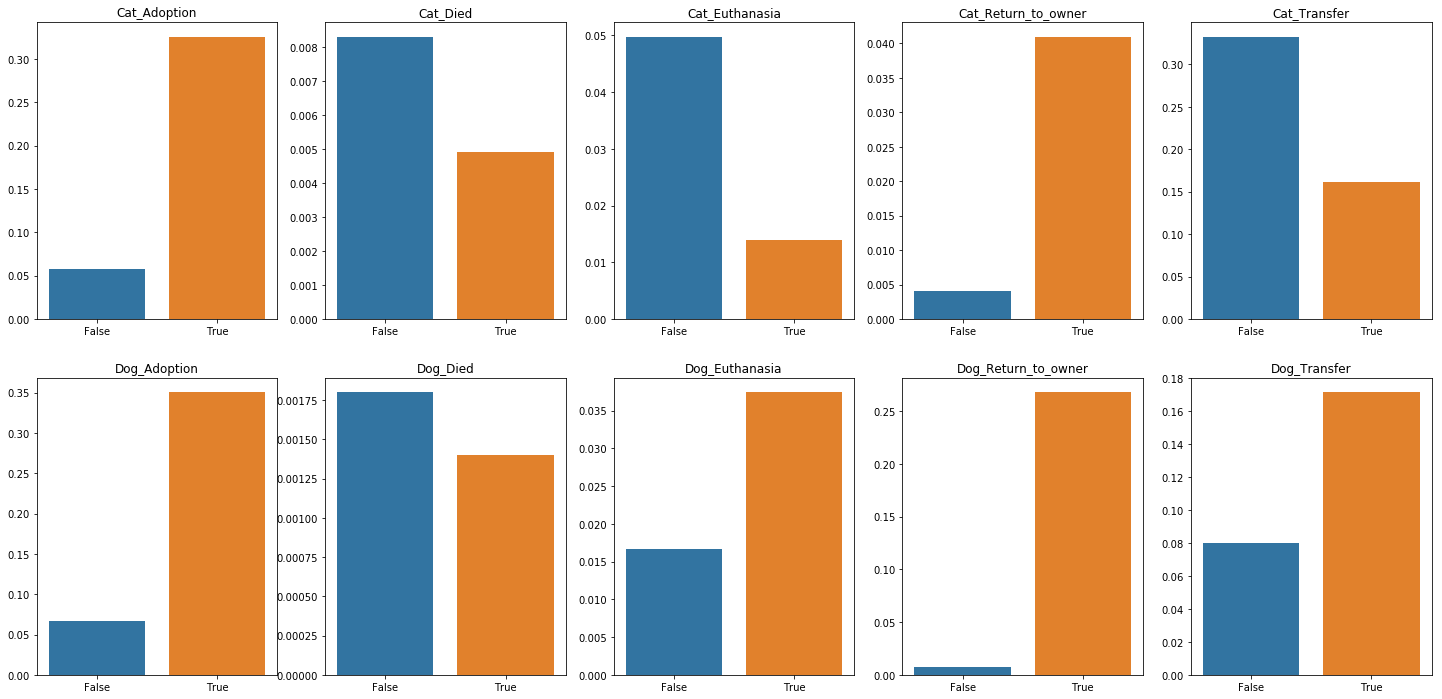

In [17]:
name_type = []
for c in train_data.Name:
    # There's large amount (about 30) of animal shows with the name 'X', 
    # so we assume 'X' is another way to indicate no name given,
    # although there's other names with only one charater other than 'X',
    # like Mr. C for a cat works for me.
    if type(c) == float or c == 'X':
        name_type.append('False')
    else:
        name_type.append('True')
train_data['HaveName'] = name_type
train_outcome_name = pd.DataFrame({'Count' : train_data.groupby(["AnimalType", "OutcomeType", 'HaveName']).size()}).reset_index()
train_outcome_name['Count_P'] = generate_Count_Prob(train_outcome_name, 4)

generate_plot('HaveName', train_outcome_name)

The result shows that a pet has a name, has a way better chance to get adopted or returned to owner. Pets without a name has a better chance to get euthanasia and died. So the name should be involved in our model.

### Summary

As we can see, from all charts above, I think the promising features are:
- HasName (is animal have a name or not)
- isAdult (is animal older than one year old or not)
- Lifestage (in six ranges)
- Sex (Female or male, there's a missing sex data and we would just replace that with random sex, either male or female')
- Intact (is the animal intact or not)
- TimeOfDay (what time of the day when the outcome type happened)
- Season (in which season did the outcome happen)
- Month (in which month did the outcome happen)
- Is Mix (for color, indicating animal have more than one color or not)
- Is Mix (for breed, indicating animal have more than one breed or not)
- Colors (for color which fell in more categories than Is Mix for color above)

In the following section, we are going to analyze the classifying performance of all these predictor variables and may be removing some less significant ones.

##### Feature importance

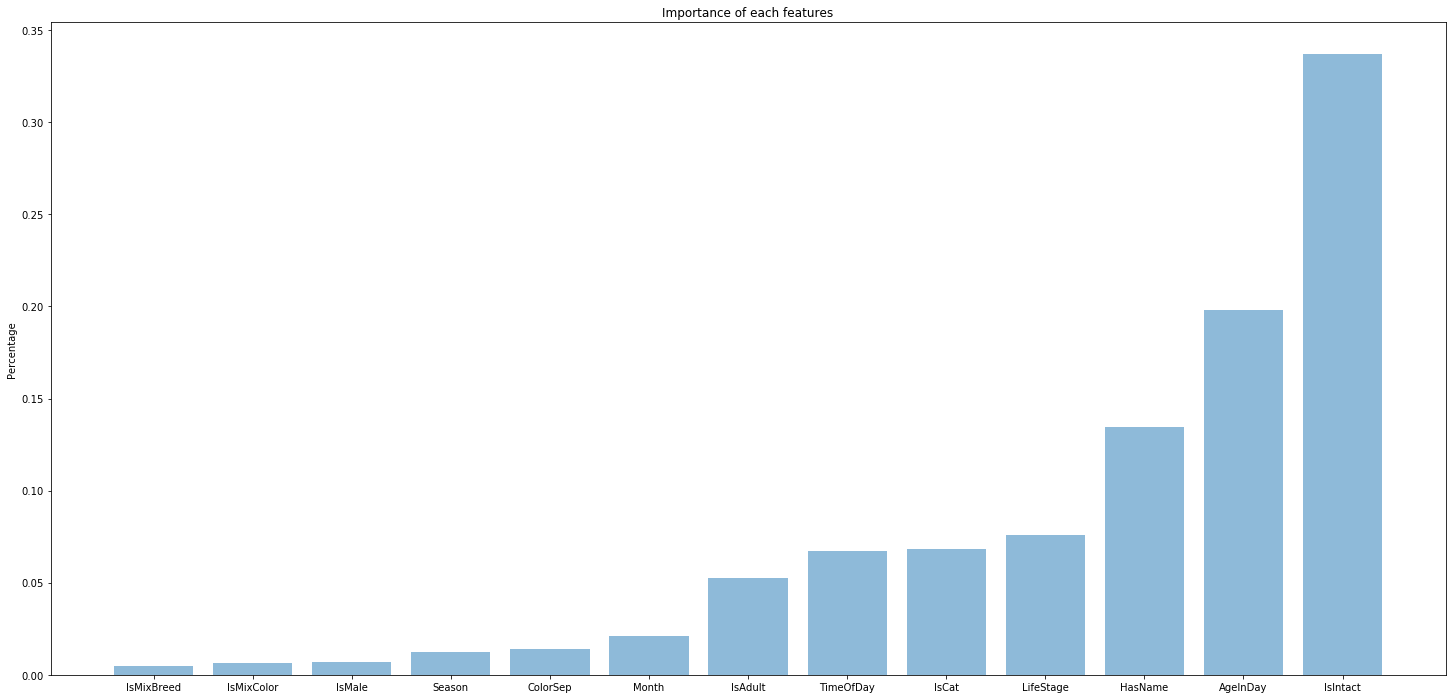

In [45]:
# We pick one of the output from random forest to generate the result
# Note: This cell need to run after random forest algorithm.
feature_import = array(list(randomForest[0][2]))
idx = np.argsort(feature_import)
feature_import = sort(feature_import)
y_pos = np.arange(len(feature_import))
plt.bar(y_pos, feature_import, alpha=0.5)
plt.xticks(y_pos, [cols[i+1] for i in idx])
plt.ylabel('Percentage')
plt.title('Importance of each features')
plt.show()

From the plot, whether the animal is intact or not actually the most important feature. The animal's age and if their names are picked yet are also an important indication.

## Section II
## Algorithms Analysis

#### Extract Feature
In this part we extract all the feature we needed into numerical style.

In [18]:
def extract_features(data, test=False):
    cols = []
    if not test:
        data["Outcome"] = data["OutcomeType"].apply(outcomes)
        cols.append('Outcome')
    data['HasName'] = data['Name'].apply(has_name)
    cols.append('HasName')
    data['IsMale'] = data['SexuponOutcome'].apply(is_male)
    cols.append('IsMale')
    data['IsIntact'] = data['SexuponOutcome'].apply(is_intact)
    cols.append('IsIntact')
    data['AgeInDay'] = data['AgeuponOutcome'].apply(age_to_day)
    # Replace nan data to mean in age
    data['AgeInDay'].fillna(data['AgeInDay'].mean(), inplace=True)
    cols.append('AgeInDay')
    data['IsAdult'] = data['AgeInDay'].apply(lambda age_in_days: 0.0 
                                                   if age_in_days < 365 else 1.0)
    cols.append('IsAdult')
    data['LifeStage'] = data['AgeInDay'].apply(inLife)
    cols.append('LifeStage')
    data['TimeOfDay'] = data['DateTime'].apply(get_time)
    cols.append('TimeOfDay')
    data['Season'] = data['DateTime'].apply(get_season)
    cols.append('Season')
    data['Month'] = data['DateTime'].apply(get_month)
    cols.append('Month')
    data['IsMixBreed'] = data['Breed'].apply(is_Mix)
    cols.append('IsMixBreed')
    data['IsMixColor'] = data['Color'].apply(is_Mix_C)
    cols.append('IsMixColor')
    data['ColorSep'] = data['Color'].apply(color_sep)
    cols.append('ColorSep')
    data['IsCat'] = data['AnimalType'].apply(isCat)
    cols.append('IsCat')
    return data, cols

In [19]:
# Below is about 13 help functions that we used to seperate the data.
# Extract animal type, cat is 1 and dog is 0
def isCat(animal_type):
    if animal_type == 'Cat':
        return 1.0
    else:
        return 0.0

In [20]:
# Extact color type.
def color_sep(c):
    if 'Tan' in c:
        return 1
    elif 'Silver' in c:
        return 2
    elif 'Blue' in c:
        return 3
    elif 'Gray' in c:
        return 4
    elif 'Yellow' in c:
        return 5
    elif 'Brown' in c:
        return 6
    elif 'White' in c:
        return 7
    elif 'Black' in c:
        return 8
    else:
        return 9

In [21]:
# Extract color type, where if there more than one color exist, return 1.
def is_Mix_C(color):
    if '/' in color:
        return 1.0
    else:
        return 0.0

In [22]:
# Extract breed type, see if it's a mix breed or not. 
def is_Mix(breed):
    if 'Mix' in breed or '/' in breed:
        return 1.0
    else:
        return 0.0

In [23]:
# Life stage according to the range we have in section 1, lifestages.
def inLife(age):
    if age < 365/2:
        return 1
    elif age < 365*3:
        return 2
    elif age < 365*7:
        return 3
    elif age < 365*11:
        return 4
    elif age < 365*15:
        return 5
    else:
        return 6

In [24]:
# Extract outcome type into numbers
def outcomes(outcomeType, oc = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']):
    return oc.index(outcomeType)

In [25]:
# Extract name features, to make those animals have name is 1.0, otherwise is 0.0
def has_name(name):
    if type(name) == float or name == 'X':
        return 0.0
    else:
        return 1.0

In [26]:
# Functions to check whether animal is male, which unknown will return .5
def is_male(sex):
    if sex == 'Unknown' or type(sex) == float:
        return int(round(random.random(), 0))
    if 'Male' in sex:
        return 1.0
    elif 'Female' in sex:
        return 0.0

In [27]:
# Functions to check whether animal is intact, which unknown will return .5
def is_intact(sex):
    if sex == 'Unknown' or type(sex) == float:
        return int(round(random.random(), 0))
    elif 'Intact' in sex:
        return 1.0
    else:
        return 0.0

In [28]:
# Transfer age to days. 
def age_to_day(time):
    if type(time) == float:
        return nan
    c = time.split(' ')
    if c[1] == 'month' or c[1] == 'months':
        return int(c[0]) * 30.0
    elif c[1] == 'year' or c[1] == 'years':
        return int(c[0]) * 365.0
    elif c[1] == 'week' or c[1] == 'weeks':
        return int(c[0]) * 7.0
    else:
        return float(c[0])

In [29]:
# Extract month from 'date'
def get_month(time):
    c = int(time.split(' ')[0].split('-')[1])
    return c

In [30]:
# Extract season from 'date'
def get_season(time):
    c = int(time.split(' ')[0].split('-')[1])
    if c < 3 or c == 12:
        return 1.0
    elif c < 6:
        return 0.25
    elif c < 9:
        return 0.5
    elif c < 12:
        return 0.75
    else:
        return 0.0

In [31]:
# Extract time of day from 'date'.
def get_time(time):
    c = int(time.split(' ')[1].split(':')[0])
    if c < 6:
        return 0.25
    elif c < 12:
        return 0.5
    elif c < 18:
        return 0.75
    else:
        return 1.0

#### Generate Test and true data

In [32]:
# We will use Stratified K Fold method to randomly seperate the train data for performance analysis.
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

In [33]:
skf=StratifiedKFold(n_splits=5, shuffle=True)
# Extract the predicting features from data
data, cols = extract_features(train_data)
# Seperate the data into train part and target part
data_train = data.loc[:, cols].drop('Outcome', axis=1).as_matrix()
target = data['Outcome'].as_matrix()
# Use skf to randomly seperate the data into five different sets.
train_set = []
test_set = []
for train_idx, test_idx in skf.split(data, target):
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]
    train_set.append((X_train, y_train))
    test_set.append((X_test, y_test))

In [34]:
# transfer the train and test data back to pandas format for better visualization
X_train_table = []
y_train_table = []
X_test_table = []
y_test_table = []
for i in range(len(train_set)):
    X_train_table.append(pd.DataFrame.from_records(train_set[i][0], columns=cols[1:]))
    y_train_table.append(train_set[i][1])
for i in range(len(test_set)):
    X_test_table.append(pd.DataFrame.from_records(test_set[i][0], columns=cols[1:]))
    y_test_table.append(test_set[i][1])

In [35]:
# Help function to check performance and logloss.
def performance_count(predicts, logloss = False): 
    avg = []
    loss = [0]
    for idx, predict in enumerate(predicts):
        count = 0
        if logloss:
            predict_prob = predict[1]
            predict = predict[0]
        for i, p in enumerate(predict):
            # print int(p), y_test_table[idx][i]
            if int(round(p)) == y_test_table[idx][i]:
                count += 1
        avg.append(float(count) / len(predict))
        if logloss:
            loss.append(log_loss(y_test_table[idx], predict_prob))
        print 'Match Percentage:', round(avg[-1] * 100, 2), '%', 'Log loss:', loss[-1], '\n'
    print 'Average Match Percentage:', round(sum(avg)*100/5.0, 2), '%', 'Average Log loss:', sum(loss)/5.0, "\n"
    return avg, loss

#### LinearRegression

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
def linearReg(X_train, y_train, X_test):
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

In [38]:
linear = []
for i in range(len(X_train_table)):
    linear.append(linearReg(X_train_table[i], y_train_table[i], X_test_table[i]))
linear_avg, linear_loss = performance_count(linear)

Match Percentage: 10.98 % Log loss: 0 

Match Percentage: 10.55 % Log loss: 0 

Match Percentage: 10.57 % Log loss: 0 

Match Percentage: 10.87 % Log loss: 0 

Match Percentage: 11.56 % Log loss: 0 

Average Match Percentage: 10.91 % Average Log loss: 0.0 



The first algorithm we tried to fit is a linear model, which turned out to be not very efficient. It is only about 10% of the predicted match the to the true outcome type in the test data. Hence we are dropping this model in our final report. Thus, we are not adopting this technique as our final submission.

#### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
def LogRegression(X_train, y_train, X_test):
    clf = LogisticRegression(random_state=1, max_iter=1000)
    clf.fit(X_train, y_train)
    return clf.predict(X_test), clf.predict_proba(X_test)

In [41]:
logistic = []
for i in range(len(X_train_table)):
    logistic.append(LogRegression(X_train_table[i], y_train_table[i], X_test_table[i]))
logistic_avg = performance_count(logistic, logloss=True)

Match Percentage: 61.89 % Log loss: 0.909842478217 

Match Percentage: 62.02 % Log loss: 0.908785456189 

Match Percentage: 64.04 % Log loss: 0.878602486678 

Match Percentage: 63.84 % Log loss: 0.888803488227 

Match Percentage: 62.14 % Log loss: 0.909975099379 

Average Match Percentage: 62.79 % Average Log loss: 0.899201801738 



Logistic regression is what we used in our first submission. By using its default parameters in Logistic Regression, the result performed 0.903 for the log loss. It is not bad but still expected to be improved. Please see details in our submission report.

#### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
def RandomForest(X_train, y_train, X_test):
    clf = RandomForestClassifier(n_estimators=278,
                                 min_samples_split=100, 
                                 min_samples_leaf=5,
                                 random_state=0)
    clf.fit(X_train, y_train)
    return clf.predict(X_test), clf.predict_proba(X_test), clf.feature_importances_

In [44]:
randomForest = []
for i in range(len(X_train_table)):
    randomForest.append(RandomForest(X_train_table[i], y_train_table[i], X_test_table[i]))
randomForest_avg = performance_count(randomForest, logloss=True)

Match Percentage: 64.72 % Log loss: 0.846843936064 

Match Percentage: 64.95 % Log loss: 0.84140942284 

Match Percentage: 66.51 % Log loss: 0.821825619313 

Match Percentage: 66.42 % Log loss: 0.82877881218 

Match Percentage: 64.88 % Log loss: 0.846080288994 

Average Match Percentage: 65.49 % Average Log loss: 0.836987615878 



Random forest is currently the best model, which we modeled with it for all submissions except the very first one. We tried to multiple random forest models with different parameters along with different combinations of features. Please see details in our submission report. 

#### Analysis On Random Forest 
After we decide to use random forest, it's a good idea to make sure which parameter is right for us. Here's the plot compare in between different max_feature and n_estimators. Which from the final report, we figure out that "sqrt" and "log2" don't really affect our model and n_estimators = 279 will return the best result.

In [46]:
from collections import OrderedDict

def get_oob_error(ensemble_clfs, min_=15, max_=300):
    # Mapping a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
    
    for label, clf in ensemble_clfs:
        for i in range(min_, max_ + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X_train_table[0], y_train_table[0])

            # Record the OOB error for each setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))
    return error_rate

# Help function to generate the plot
def get_plot(error_rate, tests=[], xlabel='n_estimators', min_=15, max_=300):
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        tests.append((label, xs, ys))
        plt.plot(xs, ys, label=label)

    plt.xlim(min_, max_)
    plt.xlabel(xlabel)
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()


In [48]:
# Test on max_features
# Note: This cell needs time to run, don't rerun if not necessary.
test_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, max_features="sqrt",
                               oob_score=True, random_state=0)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, random_state=0)),
    ("RandomForestClassifier, max_features='None'",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, random_state=0))
]
error_rate = get_oob_error(test_clfs, min_=15, max_=300)

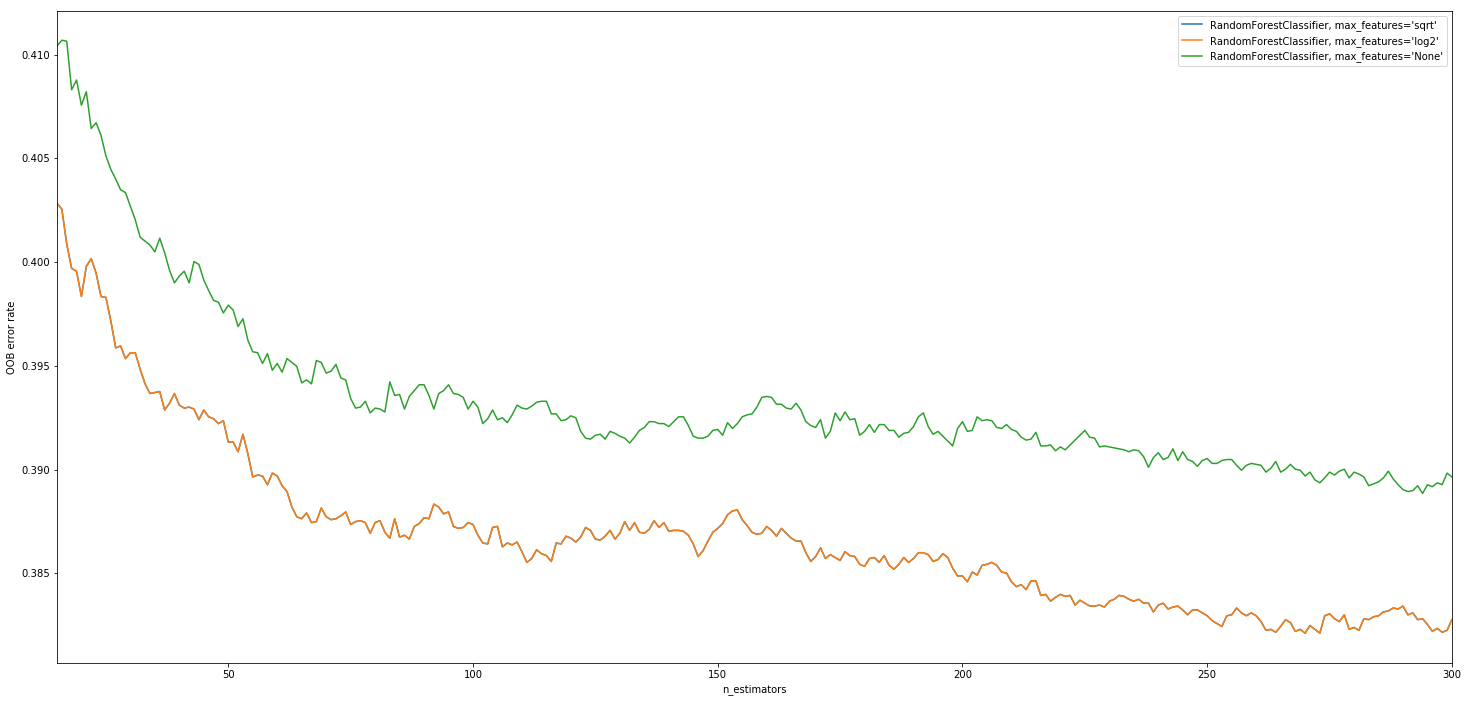

In [49]:
# Show plot using result from above cell.
get_plot(error_rate)

As we can see, sqrt and log2 are are effect the error at all, just make sure not use 'None' As our max feature. We did figure out the best performance on n_estimators which is how we decide our parameters.

## Section III
## Actual Performance
In this section, we present the code to generate the predicting results from the train and their corresponding true outcome type in test data, and then saving the data into a csv file.

In [50]:
X_train, train_cols = extract_features(train)
y_train = X_train['Outcome']
X_train = X_train.loc[:, train_cols].drop('Outcome', axis=1)

X_test, test_cols = extract_features(test, test=True)
X_test = X_test.loc[:, test_cols]

In [51]:
oc = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

#### Logistic Regression
- We tried the Logistic Regression model in our first submission, with log loss scores at 0.903.

In [52]:
logistic_res = LogRegression(X_train, y_train, X_test)
logistic_res_table = pd.DataFrame.from_records(logistic_res[1], columns=oc)
# Hard code 11457 is test set volume
logistic_res_table.insert(0, 'ID', range(1, 11457))
# Save into csv form
CSV_FILE='/Users/JohnnyLiu/Desktop/Logistic_res.csv'
logistic_res_table.to_csv(CSV_FILE, index=False)

#### Random Forest
- Second Submission, 0.8605
- Third submission, 0.85541
- Fourth submission, 0.85375 with color and breed added
- Fifth submission, 0.81686 ranking at #687 

In [53]:
RandomForest_res = RandomForest(X_train, y_train, X_test)
RandomForest_res_table = pd.DataFrame.from_records(RandomForest_res[1], columns=oc)
RandomForest_res_table.insert(0, 'ID', range(1, 11457))
# Save into a csv file
CSV_FILE='/Users/JohnnyLiu/Desktop/RandomForest_res.csv'
RandomForest_res_table.to_csv(CSV_FILE, index=False)

## SECTION IV
## Submission Report

Here is the detailed report about our submission details.

First Submission:
    - Algoirthm: Logistic Regression:
    - Logloss: 0.903
    - Features: 'HasName', 'IsMale', 'IsIntact', 'AgeInDay', 'IsAdult', 'LifeStage', 'TimeOfDay', 'Season'.
    - Detail: This submission is the first attempt to check our model efficiency. At this point, we were using the features shown above. Compared to the model of Random Forest with no parameters, Logistic Regression has a better logloss score, than that of the random forest model (about 1.3) with the same features included.

Second Submission:
    - Algoirthm: Random Forest:
    - Logloss: 0.8605
    - Features: 'HasName', 'IsMale', 'IsIntact', 'AgeInDay', 'IsAdult', 'LifeStage', 'TimeOfDay', 'Season'.
    - Detail: After the fisrt submission, we added some parameters to the random forest algorithm and the log loss score changed significanlty, which we submited again.

Third Submission:
    - Algoirthm: Random Forest:
    - Logloss: 0.85541
    - Features: 'HasName', 'IsMale', 'IsIntact', 'AgeInDay', 'IsAdult', 'LifeStage', 'TimeOfDay', 'Season'.
    - Detail: Tried different parameters to get better result, run a lot of combinations of parameters to get the best one for our classification. Compared with the second submission, the only difference was parameters combination for the model.

Fourth Submission:
    - Algoirthm: Random Forest:
    - Logloss: 0.85375
    - Features: 'HasName', 'IsMale', 'IsIntact', 'AgeInDay', 'IsAdult', 'LifeStage', 'TimeOfDay', 'Season', 'IsMixBreed', 'IsMixColor', 'ColorSep'.
    - Detail: We introduced three more features in our fourth submission, but the log loss score did not improve evidently.

Fifth Submission:
    - Algoirthm: Random Forest:
    - Logloss: 0.81686
    - Place: # 687
    - Features: 'HasName', 'IsMale', 'IsIntact', 'AgeInDay', 'IsAdult', 'LifeStage', 'TimeOfDay', 'Season', 'IsMixBreed', 'IsMixColor', 'ColorSep', 'IsCat'.
    - Detail: In the final submission, we introduced the animal type as one additional feature. We tried to train the data for dags and cats seperatly at the very begining so we forget to include this indicator in our final model. According to the outputs above, the log loss score significantly increased by adding this classifier, and this submission made us raking at # 687 in the leaderboard of this competition.

Things changed but not submit:
    - We tried to use less features than that we have in the train data to test about overfitting. Based on the test results in section 2, although the log loss score didn't change much, it did offer us some idea about the importance of each feature.
    - We tried other algorithms but none of them have better perforamce than that of Random Forest, so we just hold on the model of Random Forest in our submissions.